# Tensorflow

**First things first** \\
First of all, we need to import all the libraries that we will need. Oviously, we need Tensorflow's library in our module, but we also need to import numpy's module. \\
Let's also check which library versions we have available. \\


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
  
print("Numpy version:", np.__version__)
print("Tensorflow version:", tf.__version__)

Numpy version: 1.14.5
Tensorflow version: 1.10.1


**The session** \\
Tensorflow works on its own runtime. This means that the network that we design will be built and stored in a specific class that is responsible for running all the operations. This class is called Session().

In [0]:
sess = tf.Session()

We are now ready to start. Let's create an operation! We first define the elements of the operation.

In [3]:
# A matrix of weights
w_np = [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]
# A matrix of samples
x_np = [[0.1, 0.2], [0.3, 0.4]]

# Let's turn them into numpy arrays!
w_np = np.asarray(w_np)
x_np = np.asarray(x_np)

# Let's print them, to be sure they are what we expect them to be.
print(w_np)
print(x_np)

[[1. 2. 3.]
 [4. 5. 6.]]
[[0.1 0.2]
 [0.3 0.4]]


Up to now, we have been using numpy as a vehicle to build the matrices we need. To use them in Tensorflow, we need to turn them into tf.Tensor instances. Why did we go through numpy rather than creating the Tensors directly? \\

Since everything is in place, we can now define the operation. We want a simple matrix multiplication $x \cdot w$.

In [4]:
# Convert the numpy ma
w = tf.convert_to_tensor(w_np)
x = tf.convert_to_tensor(x_np)

op = tf.matmul(x, w)

print(op)

Tensor("MatMul:0", shape=(2, 3), dtype=float64)


Was this the output you were expecting? Why?

**IMPORTANT!!!** \\
As mentioned before, Tensorflow runs only when an instance of the class tf.Session() commands the operations to run! **Our operation has been defined as a graph in Tensorflow, but it has not been run yet!** \\


To run the operation we need to use the command tf.Session.run(). We already defined sess as an instance of the class tf.Sess().

In [7]:
op_run = sess.run(op)
print(op_run)
print(type(op_run))

[[0.9 1.2 1.5]
 [1.9 2.6 3.3]]
<class 'numpy.ndarray'>


Is this the result we were expecting? Let us check!

In [8]:
for i in range(x_np.shape[0]):
  for k in range(w_np.shape[1]):
    computed = ""
    result = 0.0
    for j in range(w_np.shape[0]):
      computed += str(x_np[i, j]) + " * " + str(w_np[j, k]) + " "
      if j != w_np.shape[0] - 1:
        computed += "+ "
      result += x_np[i, j]*w_np[j, k]
    print(computed + "= " + str(result))

0.1 * 1.0 + 0.2 * 4.0 = 0.9
0.1 * 2.0 + 0.2 * 5.0 = 1.2
0.1 * 3.0 + 0.2 * 6.0 = 1.5000000000000002
0.3 * 1.0 + 0.4 * 4.0 = 1.9000000000000001
0.3 * 2.0 + 0.4 * 5.0 = 2.6
0.3 * 3.0 + 0.4 * 6.0 = 3.3000000000000003


To summarize, there are three steps to run operations in Tensorflow: \\
1) Define the variables that will be used for the operation. \\
2) Define the graph in Tensorflow that will lead to the operation's output. \\
3) Run the operation previously defined using the command tf.Session.run().

# Variables, placeholders and optimizers

One of the main features in Tensorflow is that we can create Variables that can be optimized using gradient descent. \\
This is done by the command tf.get_variable(). This command takes a name and an initializer as its arguments: \\
- The name is a string that defines the name of the variable in the graph, so that the tf.Session() will be able to retrieve the correct tf.Variable() when requested.
- The initializer can be an object (as a numpy array) or a function defined in Tensorflow that will be used to randomly initialize the Variable.


Let's now define a problem we want to solve using a neural network: we have a series of 2D point and we want to teach the NN to recognize the points that fall in the unit circle centered at the origin.

In [0]:
train_X = np.random.normal(size=[100000, 2])
train_Y = np.expand_dims((np.sum(train_X**2, axis=1) <= 1).astype(np.float32), axis=1)
# print(np.sum(train_Y))

Let's define the network as a multi-layer perceptron.

In [0]:
def net(x):
  x_shape = x.get_shape().as_list()
  w1 = tf.get_variable("w1", initializer=tf.truncated_normal([x_shape[1], 10], stddev=2.0/float(x_shape[1])))
  b1 = tf.get_variable("b1", initializer=tf.constant(0.0, shape=[1, 10]))
  fc1 = tf.matmul(x, w1) + b1
  fc1 = tf.nn.relu(fc1)
  
  
  fc1_shape = fc1.get_shape().as_list()
  w2 = tf.get_variable("w2", initializer=tf.truncated_normal([fc1_shape[1], 1], stddev=2.0/float(fc1_shape[1])))
  b2 = tf.get_variable("b2", initializer=tf.constant(0.0, shape=[1, 1]))
  fc2 = tf.matmul(fc1, w2) + b2
  return fc2
  

Done! It was that easy! Our net function takes the input x, runs the defined network (that will be saved in a graph) and returns the output. \\

Now, we need to define a loss function. Fortunately, Tensorflow as a lot of loss functions already defined, but we also have the possibility to define our own losses. \\
The super-ultra-mega cool thing is that Tensorflow is able to calculate the derivatives for a lot of losses, even if manually defined! That is very akin to black magic!!!\\
Well, then. Let's define the loss!

In [0]:
def cross_entropy_loss(predictions, y):
  # Apply sigmoid with cross entropy to all logits
  cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=predictions, labels=y)
  
  # Sum all the single losses and return the scalar
  return tf.reduce_sum(cross_entropy)


We are almost ready to start our experiment! But first, we need to define an optimizer.

**IMPORTANT!!!** \\
An optimizer is a class that let's you decide which algorithm will be used to optimize the variables in our network for the task at hand. **The optimizer will take care of both the calculation and the application of the derivatives to the weights in the network**. The only required argument is the learning rate. \\
We want to use the simple gradient descent algorithm, without any fancy modification.

In [0]:
learning_rate = 0.00001
opt = tf.train.GradientDescentOptimizer(learning_rate)

We are now ready to define our operations... but one more thing. \\
Remember that everything that runs in the graph must be a tf.Tensor(). But our train_X and train_Y are not tf Tensors instances, they are numpy arrays. \\
Tensorflow has the necessity to define the graph before starting the calculations. The inputs, though, cannot be given as they are and too often we can't know beforehand the batch size and other details. \\
Tensorflow helps us in this through a class called tf.placeholder(). This class can be used to define the graph and then, later, we can "fill" the placeholder with our data.

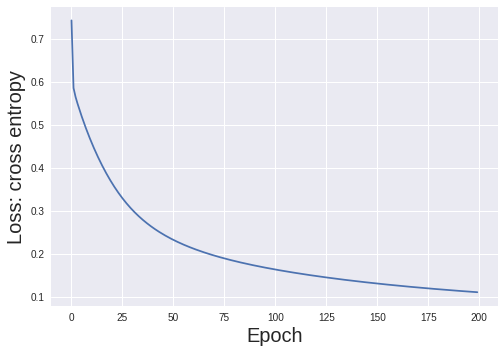

Test: 0
     7937.0
     7796.0
    Accuracy:  97.665 %


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


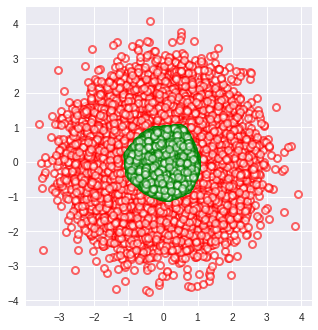

Test: 1
     7789.0
     7660.0
    Accuracy:  97.725 %


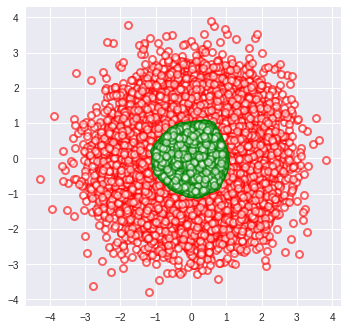

In [14]:
epochs = 200
N = float(train_X.shape[0])
### WE ARE BUILDING THE GRAPH RIGHT NOW!!!
### BEGINNING OF BUILDING GRAPH

with tf.variable_scope('circle_scope', reuse=tf.AUTO_REUSE):
  x = tf.placeholder(tf.float32, shape=[None, 2])
  y = tf.placeholder(tf.float32, shape=[None, 1])
  predictions = net(x)
  test_preds = tf.sigmoid(predictions)
  loss = cross_entropy_loss(predictions, y)
  tf.get_variable_scope().reuse_variables()

### END OF BUILDING GRAPH

### BE SURE YOU INITIALIZE THE VARIABLES IN THE GRAPH:
sess.run(tf.global_variables_initializer())

# Define the operation that will modify the weights!
step = opt.minimize(loss)
losses = []
for i in range(epochs):
#   print("epoch: ", str(i))
  randomize = np.arange(train_X.shape[0])
  np.random.shuffle(randomize)
  train_X = train_X[randomize]
  train_Y = train_Y[randomize]
  _, current_loss = sess.run([step, loss], feed_dict={x: train_X, y: train_Y})
  losses.append(current_loss/N)
  
plt.plot(range(len(losses)), losses)
plt.ylabel("Loss: cross entropy", size=20)
plt.xlabel("Epoch", size=20)
plt.show()

  
with tf.variable_scope('circle_scope', reuse=tf.AUTO_REUSE):
  x_test = tf.placeholder(tf.float32, shape=[None, 2])
  predictions_test = net(x_test)
  predictions_test = tf.sigmoid(predictions_test)
  tf.get_variable_scope().reuse_variables()

for i in range(2):
  test_X = np.random.normal(size=[20000, 2])
  test_Y = np.expand_dims((np.sum(test_X**2, axis=1) <= 1).astype(np.float32), axis=1)
  preds = np.squeeze(sess.run(predictions_test, feed_dict={x_test: test_X}))
  preds = (preds >= 0.5).astype(np.float32)
  
  print("Test:", str(i))
  print("    ", np.sum(test_Y))
  print("    ", np.sum(preds))
  print("    Accuracy: ", (1.0 - np.sum(np.abs(preds - np.squeeze(test_Y)))/float(20000))*100, "%")
  pos = np.squeeze(test_X[np.where(preds == 1), :])
  neg = np.squeeze(test_X[np.where(preds != 1), :])
  plt.scatter(neg[:, 1], neg[:, 0], c='w', edgecolors='r', linewidths=2, alpha=0.6)
  plt.scatter(pos[:, 1], pos[:, 0], c='w', edgecolors='g', linewidths=2, alpha=0.6)
  plt.axes().set_aspect('equal')
  plt.show()


# Thing to remember about Tensorflow

- Tensorflow does not compute anything if it is not run with the command tf.Session.run(). This command takes as argument the operations that we want to run and, in case the graph is fed by a tf.placeholder, a feed_dict. The argument feed_dict is a dictionary for which the kesy are the placeholders and the values are the numpy arrays that correspond to the inputs for the network. \\
- After running the graph, Tensorflow returns the numpy arrays. We cannot access values inside the tf.Tensor() directly. We first need to run the operation. \\
- We need to initialize the graph before been able to use it. For example, when training a NN, we need to build the graph, then we can iterate through the epochs and run the operations on the build graph to train th NN. \\
- Scopes in Tensorflow define where the variables are stored. We cannot initialiaze the same variable more than once. If we want to use the trained variables, we need to specify the scope and set the reuse argument to tf.AUTO_REUSE when initializing the graph!! \\
- The class tf.placeholder() must be used to be able to feed external inputs in the graph. \\